In [1]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential

In [18]:
train_dir = os.path.join('data','train')
test_dir = os.path.join('data','test')
val_dir = os.path.join('data','valid')

In [10]:
def view_random_image(target_dir, target_class):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  
  return img

Image shape: (453, 680, 3)


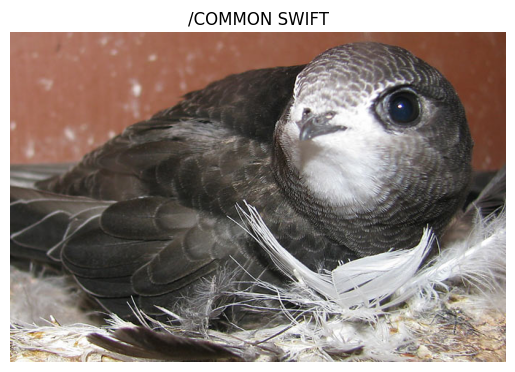

In [12]:
img = view_random_image(target_dir = train_dir,
                        target_class = '/COMMON SWIFT'
                        )

In [13]:
img.shape

(453, 680, 3)

Image shape: (183, 275, 3)
Image shape: (224, 224, 3)
Image shape: (1067, 1600, 3)


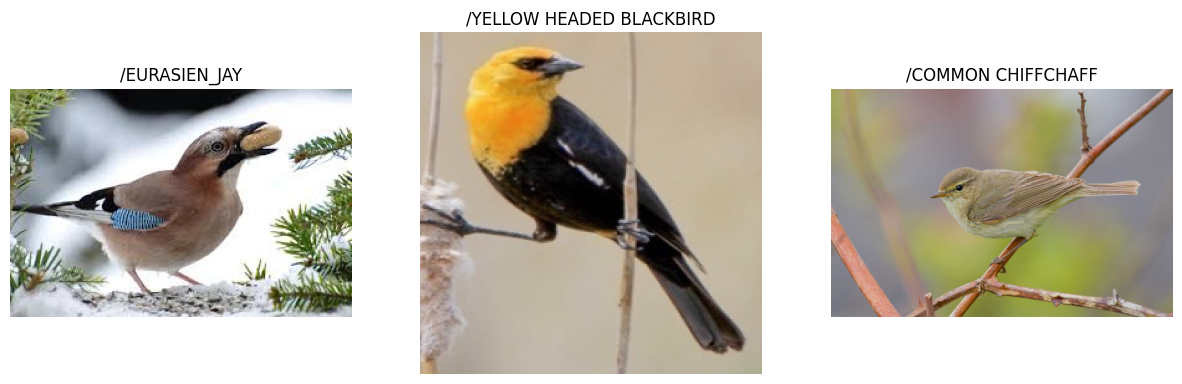

In [16]:
plt.figure(figsize = (15,7))
plt.subplot(1,3,1)
steak_image = view_random_image(train_dir, "/EURASIEN_JAY")
plt.subplot(1,3,2)
pizza_image = view_random_image(train_dir, "/YELLOW HEADED BLACKBIRD")
plt.subplot(1,3,3)
pizza_image = view_random_image(train_dir, "/COMMON CHIFFCHAFF")

In [19]:
# Rescale
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# data transfer from directories to batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (300,300),
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (300,300),
                                               class_mode = "categorical")

val_data = valid_datagen.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (300,300),
                                               class_mode = "categorical")

Found 73023 images belonging to 474 classes.
Found 2370 images belonging to 474 classes.
Found 2370 images belonging to 474 classes.


In [20]:
img_height = 150
img_width = 150
epoch_num = 10

In [23]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.InceptionV3(include_top= False,)

# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(img_height,img_width,3), name = "input-layer")

#4. Rescaling
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(474, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model_p150_e10 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_p150_e10.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.03),
                metrics = ["accuracy"])

Shape after passing inputs through base model: (None, 3, 3, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)


In [24]:
history = model_p150_e10.fit(train_data,
                                 epochs=epoch_num,
                                 steps_per_epoch = len(train_data),
                                 validation_data = val_data,
                                 validation_steps = int(0.25*len(val_data)),)

Epoch 1/10


2022-11-03 15:26:47.603556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2282/2282 [==============================] - ETA: 0s - loss: 14.7259 - accuracy: 0.4816

2022-11-03 15:43:57.172126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2282/2282 [==============================] - 1039s 454ms/step - loss: 14.7259 - accuracy: 0.4816 - val_loss: 8.5923 - val_accuracy: 0.6840
Epoch 2/10
2282/2282 [==============================] - 984s 431ms/step - loss: 9.8482 - accuracy: 0.6873 - val_loss: 8.8293 - val_accuracy: 0.7483
Epoch 3/10
2282/2282 [==============================] - 1220s 534ms/step - loss: 8.3081 - accuracy: 0.7541 - val_loss: 9.8689 - val_accuracy: 0.7066
Epoch 4/10
2282/2282 [==============================] - 1207s 529ms/step - loss: 7.2257 - accuracy: 0.7925 - val_loss: 7.7405 - val_accuracy: 0.7778
Epoch 5/10
2282/2282 [==============================] - 1162s 509ms/step - loss: 6.3295 - accuracy: 0.8208 - val_loss: 6.4416 - val_accuracy: 0.8056
Epoch 6/10
2282/2282 [==============================] - 1364s 598ms/step - loss: 5.6434 - accuracy: 0.8415 - val_loss: 7.4994 - val_accuracy: 0.8247
Epoch 7/10
2282/2282 [==============================] - 1306s 572ms/step - loss: 5.0036 - accuracy: 0.8607 - val_loss

In [25]:
# Save the entire small model as a SavedModel.
#!mkdir -p saved_model
model_p150_e10.save('saved_model_raj/model_p150_e10_eu_birds')

2022-11-03 20:06:08.848742: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model_raj/model_p150_e10_eu_birds/assets


INFO:tensorflow:Assets written to: saved_model_raj/model_p150_e10_eu_birds/assets


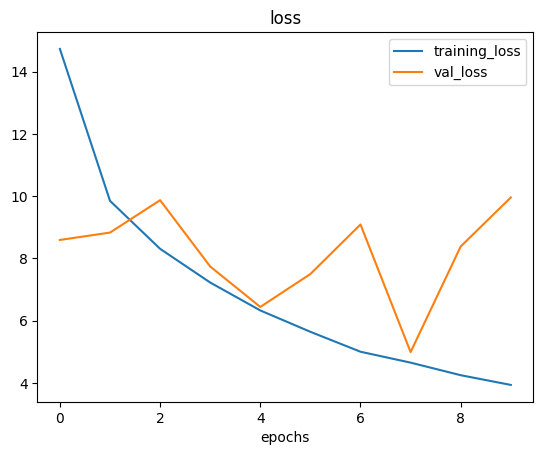

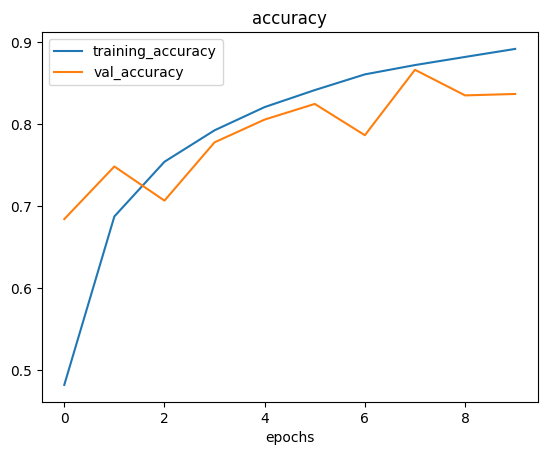

In [26]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_loss_curves(history)

# Predictions

In [27]:
# cReating a function that preprocess the custom data
def load_and_prep_image(filename, img_shape = img_height):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [28]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);